# Introduction

The following uses sklearn's AdaBoost to fit a classifier that distinguishes between a pair of sketch categories from the Quick, Draw! dataset from Google:

https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap/?pli=1

Categories were chosen below to make a somewhat difficult comparison (two objects that typically look alike)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import copy
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, cross_validate
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from utilities import computeLearningCurve, plotScoreCurve, plotTimeCurve, plotIterationCurve, plotConfusionMatrix, getDrawData, drawIncorrectSketches, heatmap

C:\Users\Scribs\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Settings

In [3]:
# Random seed used for all "random" generators
randomSeed = 1

# Number of parallel jobs used for some sklearn routines (-1 means use all cpus)
njobs = -1

# Fractional size of test dataset
testSize = 1/5.

# Number of folds for GridSearchCV
nfolds = 5

# Settings to control which features are used
pRows = 28
pCols = 28
pColNames = list(range(pRows * pCols))
pScale = 255.0 # Scale factor for pixels.  Pixel raw data is 0 to 255.  Set to 1 to avoid scaling

# Number of samples PER CATEGORY (defined below)
nSamples = 7500

# Names of all models to include
# names = ['baseball', 'basketball', 'camel', 'cow', 'clock', 'wristwatch']
names = ['baseball', 'basketball']

# Plot min/max extents for all accuracy plots
accuracyMin = 0.6
accuracyMax = 1.0

# Folds (denoted by number of data points used) for learning curve
learningCurveFolds = np.concatenate([np.geomspace(10, 1000, 5).round(), np.array([2000, 4000, 6000, 9000])]).astype('int')

In [4]:
# Used for plot names
est = "quickdraw_adaboost"
scoreText = "Score (Classification Accuracy)"

# Load Data

In [5]:
dataDict = getDrawData(names, nSamples=nSamples)
data = dataDict['df']
nameDict = dataDict['nameDict']

print("")
print("Loaded the following named categories, with classNumbers shown")
print(nameDict)

# Scale pixel data
for col in pColNames:
    data[col] = data[col] / pScale

Loading 7500 samples for baseball from ./data/full_numpy_bitmap_baseball.npy
Loading 7500 samples for basketball from ./data/full_numpy_bitmap_basketball.npy

Loaded the following named categories, with classNumbers shown
{'baseball': 0, 'basketball': 1}


In [6]:
# Create X, y, XTest, yTest using just the features we care about...

XFull = data.loc[:, pColNames].values
print(f'XFull.shape = {XFull.shape}')
yFull = data.loc[:, 'classNumber'].values
print(f'yFull.shape = {yFull.shape}')

X, XTest, y, yTest = train_test_split(XFull, yFull, test_size=testSize, 
                                      random_state=randomSeed, stratify=yFull)

print('')
print(f'X.shape = {X.shape}')
print(f'y.shape = {y.shape}')
print(f'Ratio of y=1 to y=0 for Training data: {(y == 1).sum() / float(len(y))} (should be 0.5)')

print('')
print(f'XTest.shape = {XTest.shape}')
print(f'yTest.shape = {yTest.shape}')
print(f'Ratio of yTest=1 to yTest=0 for Test data: {(yTest == 1).sum() / float(len(yTest))} (should be 0.5)')

XFull.shape = (15000, 784)
yFull.shape = (15000,)

X.shape = (12000, 784)
y.shape = (12000,)
Ratio of y=1 to y=0 for Training data: 0.5 (should be 0.5)

XTest.shape = (3000, 784)
yTest.shape = (3000,)
Ratio of yTest=1 to yTest=0 for Test data: 0.5 (should be 0.5)


# Initial Parameter Setting using GridSearchCV with Nominal Data Set

Examine the hyperparameter space using GridSearchCV.

In [7]:
n_estimators = [25, 50, 75, 100, 150]
learning_rates = [0.1, 0.5, 0.75, 1.0]
paramGrid = {
#     'base_estimator': [DecisionTreeClassifier(criterion='entropy', random_state=randomSeed, max_depth=i), for i in [1, 4]],
    'n_estimators': n_estimators,
    'learning_rate': learning_rates,
}

nData = 2000
XSubset = X[:nData]
ySubset = y[:nData]

gs = GridSearchCV(AdaBoostClassifier(random_state=randomSeed), param_grid=paramGrid, cv=nfolds, n_jobs=njobs, 
                      verbose=10, return_train_score=True)

In [8]:
# fit!
print(f"Fitting model using {XSubset.shape[0]} data samples")
gs.fit(XSubset, ySubset)

pltNameSuffix = '_' + '_initial'
with open(est + pltNameSuffix + "_gs.pkl", 'wb') as fout:
    pickle.dump(gs, file=fout)

Fitting model using 2000 data samples
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  2.2min remaining:    5.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished


In [9]:
gs_results_df = pd.DataFrame(gs.cv_results_)
gs_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.267805,0.019318,0.008172,0.000979,0.1,25,"{'learning_rate': 0.1, 'n_estimators': 25}",0.760599,0.7600,0.7250,...,0.7395,0.017509,20,0.755472,0.770625,0.758125,0.771875,0.773891,0.765998,0.007629
1,3.947440,0.542950,0.027925,0.002274,0.1,50,"{'learning_rate': 0.1, 'n_estimators': 50}",0.783042,0.7775,0.7350,...,0.7520,0.026530,19,0.788618,0.793125,0.788750,0.795625,0.801999,0.793623,0.004964
2,6.758331,0.152462,0.048270,0.002721,0.1,75,"{'learning_rate': 0.1, 'n_estimators': 75}",0.800499,0.7925,0.7550,...,0.7670,0.029809,12,0.801751,0.806250,0.804375,0.805625,0.817614,0.807123,0.005468
3,10.006249,0.099822,0.060639,0.001717,0.1,100,"{'learning_rate': 0.1, 'n_estimators': 100}",0.793017,0.8000,0.7575,...,0.7710,0.029569,10,0.823014,0.820625,0.821250,0.816250,0.830731,0.822374,0.004734
4,16.785158,1.127614,0.153988,0.068946,0.1,150,"{'learning_rate': 0.1, 'n_estimators': 150}",0.800499,0.8075,0.7675,...,0.7825,0.027888,2,0.836773,0.838125,0.838750,0.833750,0.847595,0.838999,0.004631
5,2.726518,0.120399,0.018351,0.001197,0.5,25,"{'learning_rate': 0.5, 'n_estimators': 25}",0.775561,0.8025,0.7750,...,0.7730,0.022894,8,0.819262,0.820000,0.811250,0.813125,0.821986,0.817125,0.004171
6,6.355420,0.448106,0.049268,0.015877,0.5,50,"{'learning_rate': 0.5, 'n_estimators': 50}",0.780549,0.8050,0.7775,...,0.7825,0.016057,2,0.848030,0.848125,0.855000,0.836875,0.863210,0.850248,0.008705
7,10.808508,0.120976,0.057243,0.004117,0.5,75,"{'learning_rate': 0.5, 'n_estimators': 75}",0.773067,0.8025,0.7600,...,0.7800,0.022400,4,0.871169,0.856250,0.865000,0.863750,0.886321,0.868498,0.010095
8,12.157295,0.661301,0.079190,0.009621,0.5,100,"{'learning_rate': 0.5, 'n_estimators': 100}",0.785536,0.8025,0.7625,...,0.7860,0.018302,1,0.888055,0.878750,0.874375,0.874375,0.898189,0.882749,0.009195
9,19.324637,1.785989,0.128857,0.016537,0.5,150,"{'learning_rate': 0.5, 'n_estimators': 150}",0.755611,0.7825,0.7800,...,0.7775,0.016963,5,0.899937,0.886875,0.891250,0.895000,0.908807,0.896374,0.007558


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x233012a4c18>)

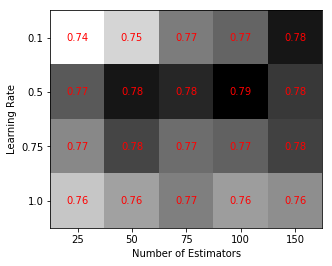

In [10]:
toPlot = np.zeros((len(learning_rates), len(n_estimators)))
for i, hls in enumerate(learning_rates):
    for j, a in enumerate(n_estimators):
        k = i * len(n_estimators) + j
        toPlot[i, j] = gs_results_df.iloc[k].mean_test_score
heatmap(toPlot, n_estimators, learning_rates, xlabel="Number of Estimators", ylabel="Learning Rate", savefig=est + pltNameSuffix + "_rbf_gs")

In [11]:
print(f'From this, we choose the following parameters for computing the learning curve:\n{gs.best_params_}')
score = gs.score(XTest, yTest)
print(f'This model has score of {gs.best_score_} in cross validation for grid search and {score} on the held-out test data')

From this, we choose the following parameters for computing the learning curve:
{'learning_rate': 0.5, 'n_estimators': 100}
This model has score of 0.786 in cross validation for grid search and 0.769 on the held-out test data


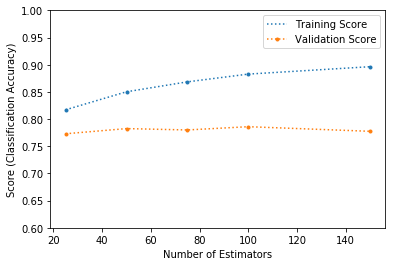

In [12]:
this_learning_rate = 0.5

fig, ax = plt.subplots()

gs_results_df.loc[gs_results_df.param_learning_rate == this_learning_rate].plot(x='param_n_estimators', y='mean_train_score', label='Training Score', ax=ax, marker='.', ls=":")
gs_results_df.loc[gs_results_df.param_learning_rate == this_learning_rate].plot(x='param_n_estimators', y='mean_test_score', label='Validation Score', ax=ax, marker='.', ls=":")

ax.set_xlabel("Number of Estimators")
ax.set_ylabel(scoreText)
ax.set_ylim(bottom=accuracyMin, top=accuracyMax)

fig.savefig(fname=est + pltNameSuffix + "_gs_lrslice")

The above results show that for moderately high learning rates, the learners are being overfit for n_estimators > ~40

# Learning Curves

Produce learning curves (train/test accuracy vs number of examples and train/score time vs number of examples) using the above chosen parameters to determine:

* Whether the classifier is bias or variance limited
* Limit to which more data points will not be helpful

In [13]:
lc_params = copy.deepcopy(gs.best_params_)

lcNameBase = est + "_" + "_lc_" + str(len(learningCurveFolds)) + "f_" + str(X.shape[0]) + "ex"
lcName = lcNameBase  + ".pkl"

print(f"Computing learning curves with params: \n{lc_params}")
print(f"Over {len(learningCurveFolds)} folds: {learningCurveFolds}")
# Note that computeLearningCurve with testSize specified splits X, y into a test and validation set 
# before training (validation set is used for validation curve)
lc = computeLearningCurve(AdaBoostClassifier(random_state=randomSeed, **lc_params), X, y, 
                          testSize = testSize,
                          learningCurveFolds=learningCurveFolds, stratifyLearningCurveFolds=True, 
                          randomSeed=randomSeed, saveas=lcName, returnEstimators=True)

Computing learning curves with params: 
{'learning_rate': 0.5, 'n_estimators': 100}
Over 9 folds: [  10   32  100  316 1000 2000 4000 6000 9000]
Indices included at fold 0: 10
	Model trained in 0.00s
	Model Scored on Training Data in 0.00s
	Model Scored on Test Data in 0.01s
	Total time for this iteration = 0.01s
Indices included at fold 1: 32
	Model trained in 0.25s
	Model Scored on Training Data in 0.01s
	Model Scored on Test Data in 0.22s
	Total time for this iteration = 0.49s
Indices included at fold 2: 100
	Model trained in 0.48s
	Model Scored on Training Data in 0.01s
	Model Scored on Test Data in 0.21s
	Total time for this iteration = 0.71s
Indices included at fold 3: 316
	Model trained in 1.06s
	Model Scored on Training Data in 0.02s
	Model Scored on Test Data in 0.22s
	Total time for this iteration = 1.31s
Indices included at fold 4: 1000
	Model trained in 2.81s
	Model Scored on Training Data in 0.06s
	Model Scored on Test Data in 0.14s
	Total time for this iteration = 3.02s
I

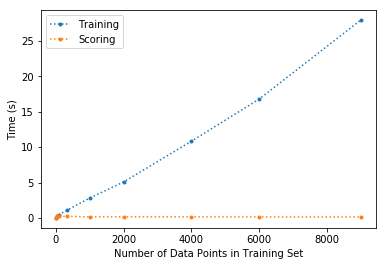

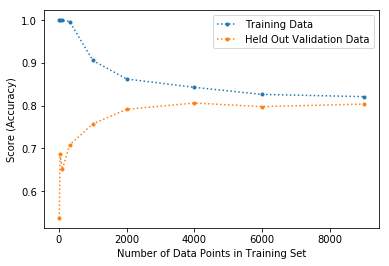

In [14]:
plotTimeCurve(lc, savefig = lcNameBase + "_time")
# plt.legend()
plt.show()

plotScoreCurve(lc, savefig = lcNameBase + "_score")
# plt.legend()
plt.show()

In [15]:
iBest = np.argmax(lc['test_score'])
bestScore = lc['test_score'][iBest]
bestData = lc['n_data'][iBest]
print(f'Best validation score of {bestScore:.3} achieved with {bestData:d} samples')

Best validation score of 0.806 achieved with 4000 samples


These results show that this AdaBoost learner is likely bias limited and requires additional complexity to improve results.

# Refit Model on Best Data

Refit the model using a second GridSearchCV search for hyperparameters, then score the model on the held out test data. 

In [16]:
n_estimators = [25, 50, 75, 100, 150]
learning_rates = [0.1, 0.5, 0.75, 1.0]
paramGrid = {
#     'base_estimator': [DecisionTreeClassifier(criterion='entropy', random_state=randomSeed, max_depth=i), for i in [1, 4]],
    'n_estimators': n_estimators,
    'learning_rate': learning_rates,
}

nData = bestData
XSubset = X[:nData]
ySubset = y[:nData]

gs = GridSearchCV(AdaBoostClassifier(random_state=randomSeed), param_grid=paramGrid, cv=nfolds, n_jobs=njobs, 
                      verbose=10, return_train_score=True)

In [17]:
# fit!
print(f"Fitting model using {XSubset.shape[0]} data samples")
gs.fit(XSubset, ySubset)
pltNameSuffix = '_final'
with open(est + pltNameSuffix + "_gs.pkl", 'wb') as fout:
    pickle.dump(gs, file=fout)

Fitting model using 4000 data samples
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   51.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  4.2min remaining:   10.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.3min finished


In [18]:
gs_results_df = pd.DataFrame(gs.cv_results_)
gs_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,3.775903,0.239998,0.024534,0.003763,0.1,25,"{'learning_rate': 0.1, 'n_estimators': 25}",0.762797,0.729089,0.73000,...,0.73150,0.016642,20,0.739294,0.752735,0.752188,0.751953,0.754764,0.750187,0.005536
1,10.706773,0.574039,0.079787,0.003338,0.1,50,"{'learning_rate': 0.1, 'n_estimators': 50}",0.795256,0.755306,0.73375,...,0.75475,0.021444,19,0.767115,0.774930,0.779687,0.769135,0.770697,0.772313,0.004494
2,16.817238,0.162400,0.121875,0.008496,0.1,75,"{'learning_rate': 0.1, 'n_estimators': 75}",0.808989,0.776529,0.74500,...,0.76725,0.023580,13,0.778681,0.789309,0.791250,0.790378,0.788504,0.787624,0.004568
3,22.903765,0.298684,0.153789,0.006414,0.1,100,"{'learning_rate': 0.1, 'n_estimators': 100}",0.807740,0.787765,0.75250,...,0.77375,0.020843,8,0.794936,0.799000,0.801875,0.802562,0.802874,0.800249,0.002989
4,34.983071,0.512559,0.232578,0.007007,0.1,150,"{'learning_rate': 0.1, 'n_estimators': 150}",0.811486,0.803995,0.76875,...,0.78650,0.017670,3,0.810878,0.813067,0.818750,0.817245,0.816932,0.815374,0.002928
5,5.835199,0.193531,0.044082,0.001323,0.5,25,"{'learning_rate': 0.5, 'n_estimators': 25}",0.794007,0.777778,0.74250,...,0.76550,0.018186,15,0.784620,0.792123,0.803438,0.799438,0.803811,0.796686,0.007353
6,11.817805,0.240682,0.094946,0.010525,0.5,50,"{'learning_rate': 0.5, 'n_estimators': 50}",0.807740,0.785268,0.76750,...,0.77875,0.016168,5,0.814630,0.814942,0.821250,0.819431,0.828803,0.819811,0.005170
7,18.180392,0.163654,0.130851,0.012172,0.5,75,"{'learning_rate': 0.5, 'n_estimators': 75}",0.817728,0.794007,0.76375,...,0.78425,0.019805,4,0.832135,0.828696,0.836562,0.829741,0.831303,0.831687,0.002715
8,24.113531,0.095503,0.177526,0.016461,0.5,100,"{'learning_rate': 0.5, 'n_estimators': 100}",0.817728,0.782772,0.77375,...,0.78825,0.015286,2,0.838700,0.839950,0.844063,0.836614,0.841612,0.840188,0.002533
9,35.307801,0.216411,0.249533,0.028694,0.5,150,"{'learning_rate': 0.5, 'n_estimators': 150}",0.816479,0.786517,0.78000,...,0.78925,0.013851,1,0.849641,0.848390,0.851875,0.850984,0.856295,0.851437,0.002702


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x23301667208>)

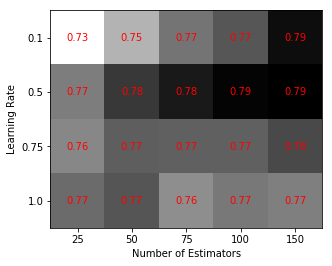

In [19]:
toPlot = np.zeros((len(learning_rates), len(n_estimators)))
for i, hls in enumerate(learning_rates):
    for j, a in enumerate(n_estimators):
        k = i * len(n_estimators) + j
        toPlot[i, j] = gs_results_df.loc[(gs_results_df.param_learning_rate == hls) & (gs_results_df.param_n_estimators == a), "mean_test_score"]
heatmap(toPlot, n_estimators, learning_rates, xlabel="Number of Estimators", ylabel="Learning Rate", savefig=est + pltNameSuffix + "_rbf_gs")

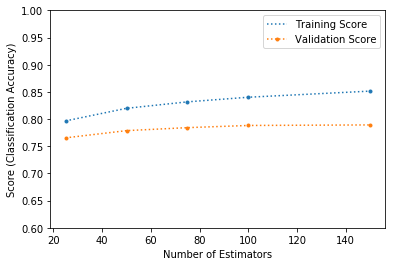

In [20]:
this_learning_rate = 0.5

fig, ax = plt.subplots()


gs_results_df.loc[gs_results_df.param_learning_rate == this_learning_rate].plot(x='param_n_estimators', y='mean_train_score', label='Training Score', ax=ax, marker='.', ls=":")
gs_results_df.loc[gs_results_df.param_learning_rate == this_learning_rate].plot(x='param_n_estimators', y='mean_test_score', label='Validation Score', ax=ax, marker='.', ls=":")

ax.set_xlabel("Number of Estimators")
ax.set_ylabel(scoreText)
ax.set_ylim(bottom=accuracyMin, top=accuracyMax)

fig.savefig(fname=est + pltNameSuffix + "_gs_lrslice")

In [21]:
print(f'From this, we choose the following parameters for computing the learning curve:\n{gs.best_params_}')
score = gs.score(XTest, yTest)
print(f'This model has score of {gs.best_score_} in cross validation for grid search and {score} on the held-out test data')

From this, we choose the following parameters for computing the learning curve:
{'learning_rate': 0.5, 'n_estimators': 150}
This model has score of 0.78925 in cross validation for grid search and 0.773 on the held-out test data


This shows similar results to those above, except that with the additional data more agressive pruning yields slightly better results. 

# Confusion Matrix

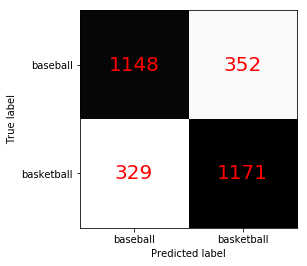

In [22]:
predictions = gs.predict(XTest)
ax = plotConfusionMatrix(yTest, predictions, names, savefig=est + pltNameSuffix + "_confusion")

# Examples of Incorrect Classifications

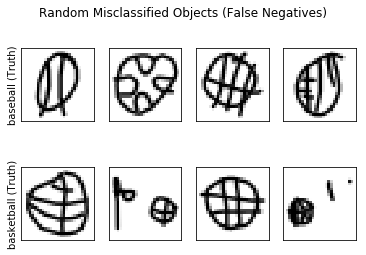

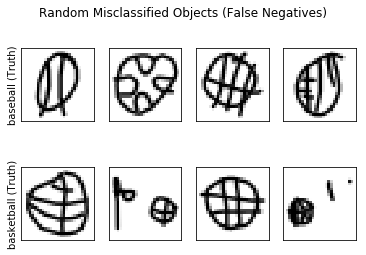

In [23]:
classNumbers = [nameDict[name] for name in names]
drawIncorrectSketches(XTest, yTest, predictions, classNumbers=[0, 1], names=names, n=4, randomSeed=randomSeed, savefig=est + pltNameSuffix + "_Misclassified")